In [1]:
import torch
import torch.nn as nn
from utils import create_dataloader
import numpy as np
from cnn import AudioModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report

/Users/stephone_christian/Desktop/wakeword/source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


In [2]:
# K fold cross validation
MODEL_PATH = "logs/audiomodel.batch_size:16.lr:0.0005.lr_schedule:5.weight_decay:0.1.weight:4.0.epochs:30/checkpoint/checkpoint_25.pth"

def run_inference():
    model = AudioModel()
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model'])
    _, test_dataloader = create_dataloader(batch_size=16)

    with torch.inference_mode():
        y_true, y_pred = [], []
        for X_val, y_val in test_dataloader:

            X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
            y_val= nn.functional.one_hot(y_val, num_classes=2).view(y_val.shape[0], 2).float()

            predictions = model(X_val)
            y_true.append(torch.argmax(y_val, dim=1))
            y_pred.append(torch.argmax(predictions, dim=1))

    y_true_np = np.concatenate([x.numpy() for x in y_true], axis=None)
    y_pred_np = np.concatenate([x.numpy() for x in y_pred], axis=None)   

    return y_true_np, y_pred_np

In [3]:
def confusion_matrix_disp(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    fig = ConfusionMatrixDisplay(conf)
    fig.plot()

In [4]:
y_true, y_pred = run_inference()

/Users/stephone_christian/Desktop/wakeword/utils.py:282: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  X = torch.from_numpy(X)


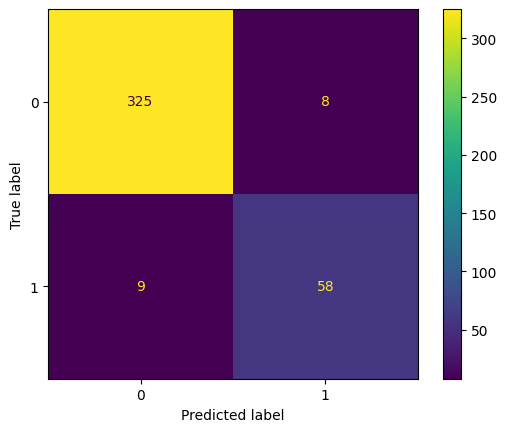

In [5]:
confusion_matrix_disp(y_true, y_pred)

In [6]:
print(classification_report(y_true, y_pred, target_names=['background', 'wakeword']))

              precision    recall  f1-score   support

  background       0.97      0.98      0.97       333
    wakeword       0.88      0.87      0.87        67

    accuracy                           0.96       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.96      0.96      0.96       400

